Integrantes  
Bryann Alfaro  
Raul Jimenez  
Donaldo Garcia

In [156]:
pip install scapy


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Parte 1 - Analisis de paquetes

 Analisis estadistico

In [157]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

REFERENCIA: JUPYTER BRINDADO EN CLASE

Capture 10 paquetes con la herramienta scapy, imprima el tipo de datos, la longitud y el
contenido del pcap

In [158]:
pcap = sniff(count=10) #captura de 10 paquetes

In [159]:
#Impresion de tipo de dato, longitud y contenido
print(type(pcap))
print(len(pcap))
for i in range(len(pcap)):
  print(pcap[i])
pcap[0]

<class 'scapy.plist.PacketList'>
10
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:62288 > 2607:f8b0:4008:814::200a:https / Raw
Ether / IP / TCP 152.199.4.33:https > 192.168.0.9:60699 A
Ether / IPv6 / UDP 2607:f8b0:4008:814::200a:https > 2803:d100:8000:17c:b92b:e265:6636:f75e:62288 / Raw
Ether / IP / UDP 192.168.0.9:60401 > 239.255.255.250:ssdp / Raw
Ether / IP / UDP 192.168.0.2:48821 > 192.168.0.9:60401 / Raw
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:62288 > 2607:f8b0:4008:814::200a:https / Raw
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:52932 > 2607:f8b0:4008:80a::200e:https / Raw
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:52932 > 2607:f8b0:4008:80a::200e:https / Raw
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:52932 > 2607:f8b0:4008:80a::200e:https / Raw
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:52932 > 2607:f8b0:4008:80a::200e:https / Raw


<Ether  dst=88:ef:16:24:55:b9 src=f4:d4:88:74:49:1d type=IPv6 |<IPv6  version=6 tc=0 fl=462080 plen=41 nh=UDP hlim=64 src=2803:d100:8000:17c:b92b:e265:6636:f75e dst=2607:f8b0:4008:814::200a |<UDP  sport=62288 dport=https len=41 chksum=0xa332 |<Raw  load='Q\\xd1ݟ\x012}\\x845\x0c\\xa7\\x8b\x15\\xac\\x840\\x96\\xc3|`\r\x02. \x04\\xed\\x86\x04#R~\\xb1\\xcd' |>>>>

Para conocer un poco mas se puede hacer la exploracion

In [160]:
ethernet_frame = pcap[0]
ip_packet = ethernet_frame.payload
segment = ip_packet.payload
data = segment.payload #recupera la informacion de la capa 4

print("Informacion del frame:")
print(ethernet_frame.summary())

print("Informacion del paquete:")
print(ip_packet.summary())

print("Informacion del segmento:")
print(segment.summary())

print("Data:")
print(data.summary())

ethernet_frame.show()
data.show()

Informacion del frame:
Ether / IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:62288 > 2607:f8b0:4008:814::200a:https / Raw
Informacion del paquete:
IPv6 / UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:62288 > 2607:f8b0:4008:814::200a:https / Raw
Informacion del segmento:
UDP 2803:d100:8000:17c:b92b:e265:6636:f75e:62288 > 2607:f8b0:4008:814::200a:https / Raw
Data:
Raw
###[ Ethernet ]### 
  dst       = 88:ef:16:24:55:b9
  src       = f4:d4:88:74:49:1d
  type      = IPv6
###[ IPv6 ]### 
     version   = 6
     tc        = 0
     fl        = 462080
     plen      = 41
     nh        = UDP
     hlim      = 64
     src       = 2803:d100:8000:17c:b92b:e265:6636:f75e
     dst       = 2607:f8b0:4008:814::200a
###[ UDP ]### 
        sport     = 62288
        dport     = https
        len       = 41
        chksum    = 0xa332
###[ Raw ]### 
           load      = 'Q\\xd1ݟ\x012}\\x845\x0c\\xa7\\x8b\x15\\xac\\x840\\x96\\xc3|`\r\x02. \x04\\xed\\x86\x04#R~\\xb1\\xcd'

###[ Raw ]### 
  load      = 'Q\

In [161]:
pcap2 = rdpcap('analisis_paquetes.pcap')

In [162]:
print(len(pcap2))

62


In [163]:
print(len(pcap))

10


Convierta el pcap a un DataFrame  
Se saca el DF de ambos pcap y luego se unen 

In [164]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos  len     id flags frag ttl proto chksum  ... dataofs   
0       4   5   0   52  35864          0  54     6  39698  ...       8  \
1       4   5   0  204  26595          0   1    17  41106  ...    None   
2       4   5   0  529  25682    DF    0  64    17  21294  ...    None   

  reserved flags  window chksum urgptr options payload   
0        0     A     136  38557      0       3       0  \
1     None  None    None  28702   None    None     176   
2     None  None    None   2197   None    None     501   

                                         payload_raw   
0                                                b''  \
1  b'M-SEARCH * HTTP/1.1\r\nHOST: 239.255.255.250...   
2  b'HTTP/1.1 200 OK\r\nCACHE-CONTROL: max-age=18...   

                                         payload_hex  
0                                                b''  
1  b'4d2d534541524348202a20485454502f312e310d0a48...  
2  b'485454502f312e3120323030204f4b0d0a4341434845...  

[3 rows x 28 columns]


In [165]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df2 = pd.DataFrame(columns=dataframe_fields)
for packet in pcap2[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df2 = pd.concat([df2, df_append], axis=0)

# Reset Index
df2 = df2.reset_index()
# Drop old index column
df2 = df2.drop(columns="index")

print(df2.head(5))

  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs   
0       4   5   0   961      1          0   64    17  21222  ...    None  \
1       4   5  32    84  58919          0  122    17  13836  ...    None   
2       4   5   0   975      1          0   64    17  21208  ...    None   
3       4   5  32    84  59493          0  122    17  13262  ...    None   
4       4   5   0  1012      1          0   64    17  21171  ...    None   

  reserved flags window chksum urgptr options payload   
0     None  None   None  62990   None    None     933  \
1     None  None   None  65061   None    None      56   
2     None  None   None  36378   None    None     947   
3     None  None   None  65063   None    None      56   
4     None  None   None  63846   None    None     984   

                                         payload_raw   
0  b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...  \
1  b'\x00\x0c\x81\x80\x00\x01\x00\x01\x00\x00\x00...   
2  b'\x00\x0c\x01\x00\x00\x01\x0

Muestre los valores de las columnas: Src Addres, Dst Address, Src Port y Dst Port

In [166]:
df_new = pd.concat([df,df2])

In [167]:
df_new.columns

Index(['version', 'ihl', 'tos', 'len', 'id', 'flags', 'frag', 'ttl', 'proto',
       'chksum', 'src', 'dst', 'options', 'time', 'sport', 'dport', 'seq',
       'ack', 'dataofs', 'reserved', 'flags', 'window', 'chksum', 'urgptr',
       'options', 'payload', 'payload_raw', 'payload_hex'],
      dtype='object')

In [168]:
df_new.shape

(65, 28)

In [169]:
df_new['src']

0     152.199.4.33
1      192.168.0.9
2      192.168.0.2
0       10.1.10.53
1      84.54.22.33
          ...     
57     84.54.22.33
58      10.1.10.53
59     84.54.22.33
60      10.1.10.53
61     84.54.22.33
Name: src, Length: 65, dtype: object

In [170]:
df_new['src'].value_counts()

src
10.1.10.53      31
84.54.22.33     29
75.75.75.75      2
152.199.4.33     1
192.168.0.9      1
192.168.0.2      1
Name: count, dtype: int64

In [171]:
df_new['dst']

0         192.168.0.9
1     239.255.255.250
2         192.168.0.9
0         84.54.22.33
1          10.1.10.53
           ...       
57         10.1.10.53
58        84.54.22.33
59         10.1.10.53
60        84.54.22.33
61         10.1.10.53
Name: dst, Length: 65, dtype: object

In [172]:
df_new['dst'].value_counts()

dst
10.1.10.53         31
84.54.22.33        29
192.168.0.9         2
75.75.75.75         2
239.255.255.250     1
Name: count, dtype: int64

In [173]:
df_new['sport']

0       443
1     60401
2     48821
0        53
1        53
      ...  
57       53
58       53
59       53
60       53
61       53
Name: sport, Length: 65, dtype: object

In [174]:
df_new['sport'].value_counts()

sport
53       60
443       1
60401     1
48821     1
15812     1
23903     1
Name: count, dtype: int64

In [175]:
df_new['dport']

0     60699
1      1900
2     60401
0        53
1        53
      ...  
57       53
58       53
59       53
60       53
61       53
Name: dport, Length: 65, dtype: object

In [176]:
df_new['dport'].value_counts()

dport
53       60
60699     1
1900      1
60401     1
15812     1
23903     1
Name: count, dtype: int64

# Estadísticas

In [177]:
#Muestre cual es la IP origen más frecuente
source_ip = df_new['src'].value_counts(ascending=False).index[0]
source_ip

'10.1.10.53'

In [178]:
#Muestre cual es la IP destino más frecuente
dest_ip = df_new['dst'].value_counts(ascending=False).index[0]
dest_ip

'10.1.10.53'

In [179]:
#¿A qué IPs se comunica la IP del inciso a?
df_new[df_new['src']==source_ip][['src','dst']]

,src,dst
0,10.1.10.53,84.54.22.33
2,10.1.10.53,84.54.22.33
4,10.1.10.53,84.54.22.33
6,10.1.10.53,84.54.22.33
8,10.1.10.53,84.54.22.33
10,10.1.10.53,84.54.22.33
12,10.1.10.53,84.54.22.33
14,10.1.10.53,84.54.22.33
16,10.1.10.53,84.54.22.33
18,10.1.10.53,84.54.22.33


In [180]:
#¿A qué puertos destino se comunica la IP del inciso a?
df_new[df_new['src']==source_ip][['src','dport']]

,src,dport
0,10.1.10.53,53
2,10.1.10.53,53
4,10.1.10.53,53
6,10.1.10.53,53
8,10.1.10.53,53
10,10.1.10.53,53
12,10.1.10.53,53
14,10.1.10.53,53
16,10.1.10.53,53
18,10.1.10.53,53


In [181]:
#¿A qué puertos origen se comunica la IP del inciso b?
df_new[df_new['dst']==dest_ip][['dst','sport']]

,dst,sport
1,10.1.10.53,53
3,10.1.10.53,53
5,10.1.10.53,53
7,10.1.10.53,53
9,10.1.10.53,53
11,10.1.10.53,53
13,10.1.10.53,53
15,10.1.10.53,53
17,10.1.10.53,53
19,10.1.10.53,53


#### Indique el propósito de los puertos que más aparece en los incisos d y e:

**En este caso el puerto que mas aparece es el puerto 53 el cual es utilizado por servicios DNS y permite usar tanto TCP como UDP para comunicarse con servidores DNS.** 

# Graficas

<Axes: ylabel='src'>

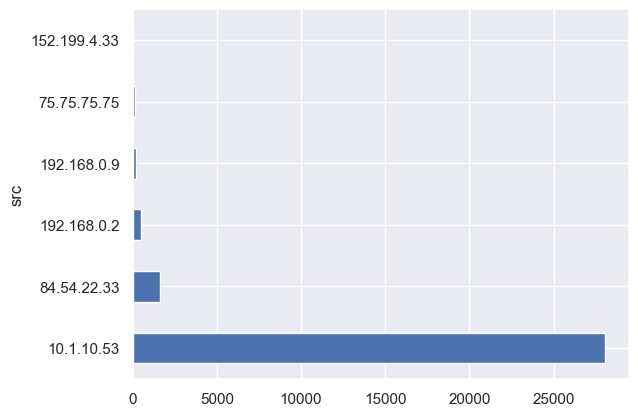

In [182]:
#Muestre una gráfica 2D, en el eje Y las IPs origen, y en el eje X la suma de los payloads
#enviados de dichas direcciones.

df_new.groupby('src')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

<Axes: ylabel='dst'>

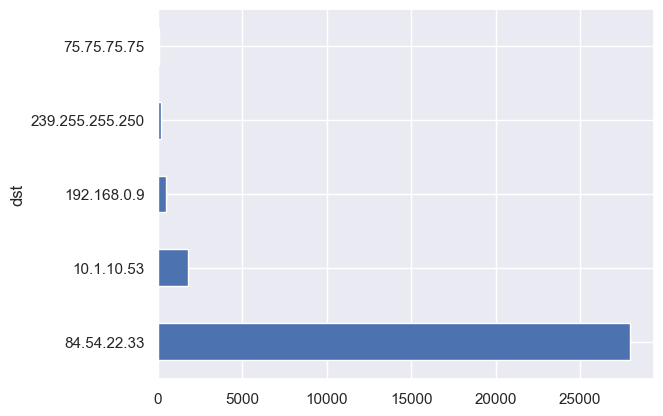

In [183]:
# Muestre una gráfica 2D, en el eje Y las IPs destino, y en el eje X la suma de los payloads recibidos en dichas direcciones.

df_new.groupby('dst')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

<Axes: ylabel='sport'>

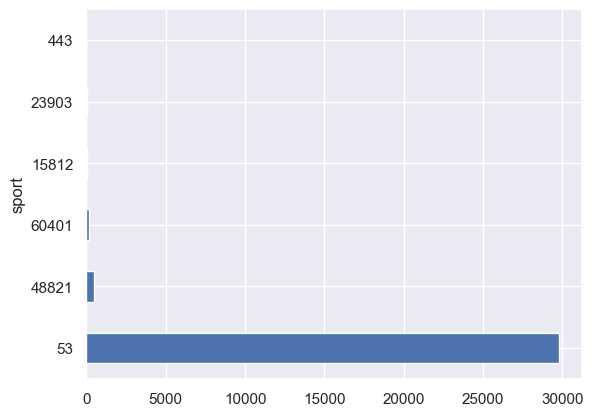

In [184]:
# Muestre una gráfica 2D, en el eje Y los puertos origen, y en el eje X la suma de los
# payloads enviados de dichos puertos.

df_new.groupby('sport')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

<Axes: ylabel='dport'>

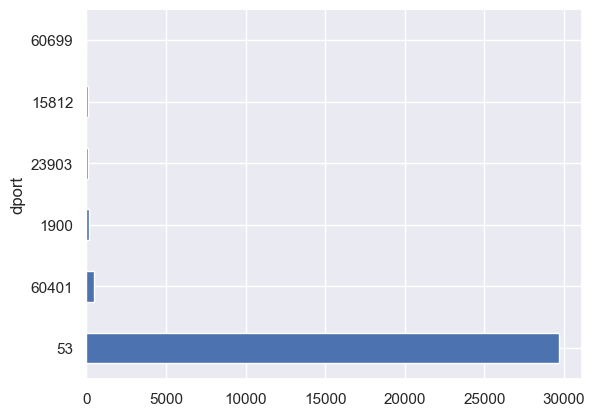

In [185]:
# Muestre una gráfica 2D, en el eje Y los puertos destino, y en el eje X la suma de los
# payloads recibidos en dichos puertos.

df_new.groupby('dport')['payload'].sum().sort_values(ascending=False).plot.barh(x='payload')

# Investigación del payload

In [186]:
# Cree un nuevo DF que incluya únicamente las conexiones con la dirección IP origen
# más frecuente

df_frecuent_ip = df_new[df_new['src']==source_ip]
df_frecuent_ip.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,...,dataofs,reserved,flags,window,chksum,urgptr,options,payload,payload_raw,payload_hex
0,4,5,0,961,1,,0,64,17,21222,...,None,None,None,None,62990,None,None,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
2,4,5,0,975,1,,0,64,17,21208,...,None,None,None,None,36378,None,None,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
4,4,5,0,1012,1,,0,64,17,21171,...,None,None,None,None,63846,None,None,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
6,4,5,0,998,1,,0,64,17,21185,...,None,None,None,None,65315,None,None,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...
8,4,5,0,1003,1,,0,64,17,21180,...,None,None,None,None,38088,None,None,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,b'000c0100000100000000000006676f6f676c6503636f...


In [187]:
# Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por
# payload

# df_frecuent_ip_new = df_frecuent_ip.groupby(['src','dst'])['payload'].sum().sort_values(ascending=False)
# df_frecuent_ip_new = df.groupby(by=["payload"])[['src', 'dst', 'payload']]
# df_frecuent_ip_new

df_frecuent_ip_new = df.groupby(by=["payload"])
df_frecuent_ip_new = df[['src', 'dst', 'payload']]
df_frecuent_ip_new

,src,dst,payload
0,152.199.4.33,192.168.0.9,0
1,192.168.0.9,239.255.255.250,176
2,192.168.0.2,192.168.0.9,501


In [188]:
# Obtenga la IP que más ha intercambiado bytes con la IP más frecuente. Esta IP es
# sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

# suspicious_ip = df_frecuent_ip_new.index[0][1]
max_payload = df_frecuent_ip['payload'].max()
max_payload

1023

In [189]:
df_suspicious_comunication = df_new[(df_new['payload'] == max_payload) & (df_new['src']==source_ip) ]
suspicious_ip = df_suspicious_comunication['dst'].values[0]
suspicious_ip

'84.54.22.33'

In [190]:
# Cree un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa.
df_comunication = df_new[(df_new['src']==source_ip) & (df_new['dst']==suspicious_ip)]
df_comunication[['src','dst','payload']]

,src,dst,payload
0,10.1.10.53,84.54.22.33,933
2,10.1.10.53,84.54.22.33,947
4,10.1.10.53,84.54.22.33,984
6,10.1.10.53,84.54.22.33,970
8,10.1.10.53,84.54.22.33,975
10,10.1.10.53,84.54.22.33,1017
12,10.1.10.53,84.54.22.33,980
14,10.1.10.53,84.54.22.33,951
16,10.1.10.53,84.54.22.33,931
18,10.1.10.53,84.54.22.33,964


In [191]:
# Obtenga los payloads del DF del inciso 6, y añada cada uno en un array

payloads_array = df_comunication['payload_raw'].to_numpy()

In [192]:
# Muestre el contenido del array.
payloads_array

array([b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00\x00\x06google\x03com\x00\x00\x1c\x00\x01\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01b\x00\x00\x00\xef\xbf\xbd\x08\x06\x00\x00\x00(\xef\xbf\xbdTR\x00\x00:\xef\xbf\xbdIDATx\xef\xbf\xbd\xef\xbf\xbd\t|T\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd;K\x12\x08;\x08\xef\xbf\xbd\nE\xef\xbf\xbd\xef\xbf\xbd$\x19\xef\xbf\xbd\xef\xbf\xbdZi\xdf\xaa-\xef\xbf\xbd;N2\xef\xbf\xbd\xef\xbf\xbdV\xef\xbf\xbdV\xef\xbf\xbda\xef\xbf\xbdZ\x11!\xef\xbf\xbd\xef\xbf\xbd\x01\xdc\xbbik[\xef\xbf\xbd.ok\xef\xbf\xbde\xef\xbf\xbd\x01\\\xef\xbf\xbd\xef\xbf\xbd]\xef\xbf\xbd-\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdd\xef\xbf\xbd\x08\xef\xbf\xbd\x08\xef\xbf\xbd\xef\xbf\xbdg\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd<\xef\xbf\xbd\xef\xbf\xbdL\x12\xef\xbf\xbd$3wf\xef\xbf\xbd\xef\xbf\xbd\x02<_\r\xef\xbf\xbdY\xef\xbf\xbdr\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\x1c\r\x18\xef\xbf\xbd8c\xef\xbf\xbdew\r\x1e\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbd\

#### Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envié a través del puerto explicado en el inciso f?

**Analizando los datos del dataframe se puede ver que estos solo se comunican a travez del puerto 53 y que estos payloads son mayormente unicos.**

In [193]:
test_port = df_comunication.groupby(by=["dport"])
test_port = df_comunication[['src', 'dst', 'payload', 'payload_raw', 'dport']]
test_port.shape

(29, 5)

In [194]:
test_port['payload'].value_counts()

payload
978     3
976     2
1009    2
933     1
941     1
999     1
989     1
977     1
991     1
985     1
982     1
1007    1
1011    1
958     1
947     1
1023    1
964     1
931     1
951     1
980     1
1017    1
975     1
970     1
984     1
560     1
Name: count, dtype: int64

In [195]:
test_port

,src,dst,payload,payload_raw,dport
0,10.1.10.53,84.54.22.33,933,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
2,10.1.10.53,84.54.22.33,947,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
4,10.1.10.53,84.54.22.33,984,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
6,10.1.10.53,84.54.22.33,970,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
8,10.1.10.53,84.54.22.33,975,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
10,10.1.10.53,84.54.22.33,1017,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
12,10.1.10.53,84.54.22.33,980,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
14,10.1.10.53,84.54.22.33,951,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
16,10.1.10.53,84.54.22.33,931,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53
18,10.1.10.53,84.54.22.33,964,b'\x00\x0c\x01\x00\x00\x01\x00\x00\x00\x00\x00...,53


### Parte 2

In [196]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier



train_df = pd.read_csv("Train_data.csv")
test_df = pd.read_csv("Test_data.csv")

In [197]:
print('Number of columns:', len(train_df.columns))
train_df.head()

numeric_data = train_df.select_dtypes(include=np.number)
numeric_data["isAttack"] = train_df["class"].apply(lambda value: 0 if value == 'normal' else 1)
numeric_data.astype(np.number)
numeric_data.head()

Number of columns: 42


/Users/sebastiangarcia/Documents/GitHub/Lab5-SecDS/env/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1687: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/sebastiangarcia/Documents/GitHub/Lab5-SecDS/env/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1687: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/sebastiangarcia/Documents/GitHub/Lab5-SecDS/env/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1687: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,isAttack
0,0,491,0,0,0,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,146,0,0,0,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,0,0,0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,232,8153,0,0,0,0,0,1,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,199,420,0,0,0,0,0,1,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [198]:
numeric_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,isAttack
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769,0.466140
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333,0.498862
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,1.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [199]:
print(numeric_data['isAttack'].value_counts())
X = numeric_data.drop(['isAttack'], axis=1)
y = numeric_data['isAttack']

isAttack
0    13449
1    11743
Name: count, dtype: int64


In [200]:
def modelCreator(data):
  X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.30, random_state=42)
  model = KNeighborsClassifier()
  model = model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  result_arbol = confusion_matrix(y_test, y_pred)

  print(result_arbol)

  print ('\nAccuracy:', accuracy_score(y_test, y_pred))
  print ("Precision:", precision_score(y_test, y_pred))
  print ("Recall: ", recall_score(y_test, y_pred))
  print ("F1: ", f1_score(y_test, y_pred))

  return model

In [201]:
def write_csv(y_preds, filename):
  array = np.asarray([y_preds])
  pd.DataFrame(array).to_csv(filename, header=False)

In [202]:
test_numeric_data = test_df.select_dtypes(include=np.number)
model = modelCreator(X)
y_pred = model.predict(test_numeric_data)

[[3988   54]
 [  59 3457]]

Accuracy: 0.9850489547499338
Precision: 0.9846197664483053
Recall:  0.9832195676905574
F1:  0.9839191689198804


In [203]:
pca = PCA(n_components=12, random_state=42)
pca_X = pca.fit_transform(X)
modelCreator(pca_X)

[[3987   55]
 [  59 3457]]

Accuracy: 0.9849166446149775
Precision: 0.9843394077448747
Recall:  0.9832195676905574
F1:  0.9837791690381331


KNeighborsClassifier()

In [204]:
pca = PCA(n_components=6, random_state=42)
pca_X = pca.fit_transform(X)
modelCreator(pca_X)

[[3990   52]
 [  58 3458]]

Accuracy: 0.9854458851548028
Precision: 0.9851851851851852
Recall:  0.9835039817974972
F1:  0.9843438656419017


KNeighborsClassifier()

In [205]:
pca = PCA(n_components=2, random_state=42)
pca_X = pca.fit_transform(X)
model = modelCreator(pca_X)

[[3989   53]
 [  39 3477]]

Accuracy: 0.987827467584017
Precision: 0.984985835694051
Recall:  0.9889078498293515
F1:  0.9869429463525405


In [206]:
pca_test_X = pca.fit_transform(test_numeric_data)
y_pred_pca = model.predict(pca_test_X)

Ambos modelos tuvieron valores muy similares en F1 que es la combinación del recall. Lo que quiere decir que ambos son altamente efectivos. Lo que nos habla mucho de los datos y la correlación que tienen entre sí que los modelos son igual de accurate.